<a href="https://colab.research.google.com/github/Safaa860/realtimeobjectdetection/blob/main/MachineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Data Collection
1.**Positive Patches(using positive patches that have been provided)**


In [ ]:
import cv2

import os,glob
import matplotlib.pyplot as plt
import numpy as np
files = glob.glob("/content/drive/MyDrive/Colab Notebooks/pedestrians128x64/*.ppm")
positive_patches=[]
for myFile in files:
        image = cv2.imread(myFile)

        numpy_images=np.array(image)
        #print(numpy_images)
        gray_image = cv2.cvtColor(numpy_images, cv2.COLOR_BGR2GRAY)
        positive_patches.append(gray_image)


**Negative Patches**

In [ ]:
from skimage import data, color

imgs_to_use = ['camera', 'text', 'coins', 'moon',
               'page', 'clock', 'immunohistochemistry',
               'chelsea', 'coffee', 'hubble_deep_field']
images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]

<ipython-input-4-8654076370ed>:6: FutureWarning: The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.
  images = [color.rgb2gray(getattr(data, name)()) for name in imgs_to_use]


In [ ]:
from sklearn.feature_extraction.image import PatchExtractor
def extract_patches(img, N, scale=1.0,
                    patch_size=positive_patches[0].shape):
    extracted_patch_size = \
        tuple((scale * np.array(patch_size)).astype(int))
    extractor = PatchExtractor(patch_size=extracted_patch_size,
                               max_patches=N, random_state=0)
    patches = extractor.transform(img[np.newaxis])
    if scale != 1:
        patches = np.array([transform.resize(patch, patch_size)
                            for patch in patches])
    return patches
scale = 1.0
negative_patches = np.vstack([extract_patches(im,95, scale)
                              for im in images])



In [ ]:
positive_patches[0].shape

(128, 64)

**Extract HOG Features**

In [ ]:
from re import X
from skimage import feature
from itertools import chain
X=np.array([feature.hog(image) for image in chain(positive_patches,negative_patches)])
y=np.zeros(X.shape[0])
y[0:950]=1

**Train-Test Split**

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y)

**Support Vector Machine Classifier**

In [ ]:
from sklearn.svm import SVC
human_detector=SVC()
human_detector.fit(X_train,y_train)

SVC()

**Gaussian naive Bayes **

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
cross_val_score(GaussianNB(), X_train, y_train)

array([0.98220641, 0.96797153, 0.98576512, 0.98932384, 0.97508897])

**Model Accuracy**

In [ ]:
human_detector.score(X_test,y_test)

0.9850746268656716

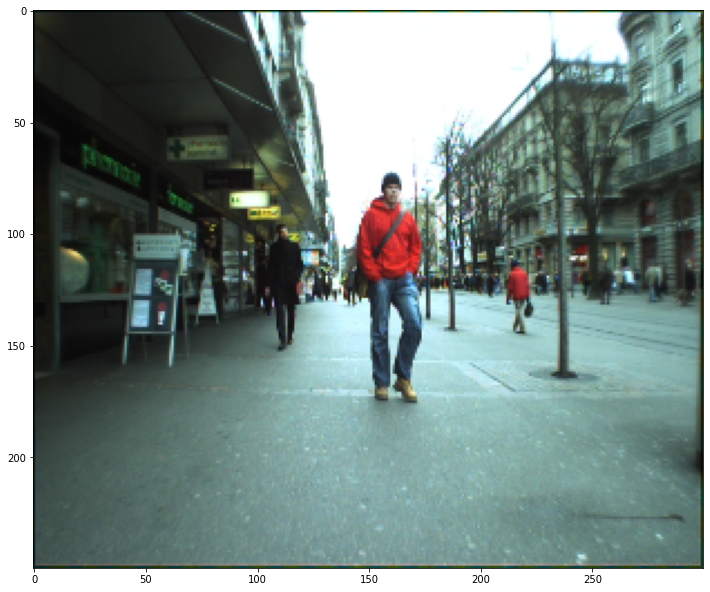

In [ ]:
import skimage
from skimage import io,color
test_image=io.imread('/content/drive/MyDrive/Colab Notebooks/image_00000006_0.png')
test_image = cv2.resize(test_image,(300,250))
test_img_gray = color.rgb2gray(test_image)
fig,axes=plt.subplots(1,1,figsize=(12,20))
axes.imshow(test_image)

**Sliding window on a Test Image**

In [ ]:
def sliding_window(image,stepSize,windowSize):
  for y in range(0,image.shape[0]-windowSize[0],stepSize):
    for x in range(0,image.shape[1]-windowSize[1],stepSize):
      patch=image[y:y+windowSize[0],x:x+windowSize[1]]
      yield(x,y),patch

In [ ]:
indices,patches=zip(*sliding_window(test_img_gray,5,positive_patches[0].shape))

In [ ]:
patches_hog=np.array([feature.hog(patch) for patch in patches])

In [ ]:
labels=human_detector.predict(patches_hog)

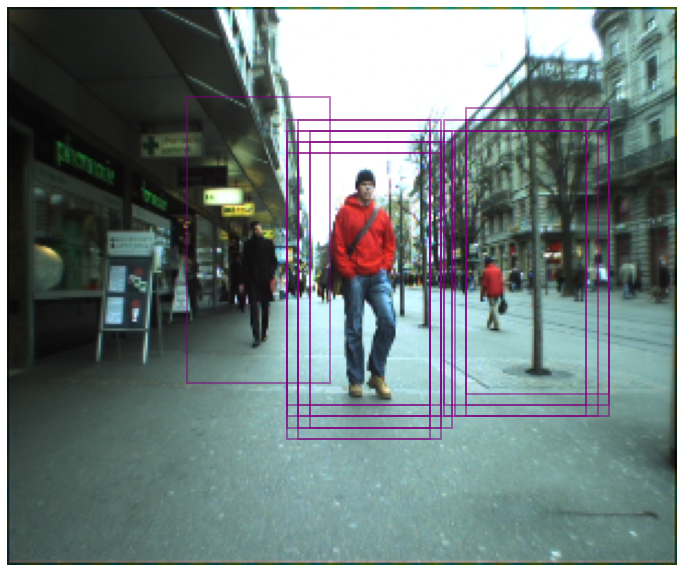

In [ ]:
from tables.index import Index
from imutils.object_detection import non_max_suppression
fig,ax=plt.subplots(figsize=(12,20))
ax.imshow(test_image)
ax.axis('off')

Ni,Nj=positive_patches[0].shape
index=np.array(indices)


for i,j in index[labels==1]:
   ax.add_patch(plt.Rectangle((i,j),Nj,Ni,edgecolor='purple',
             alpha=0.5,lw=2,facecolor='none'))


**Apply Non-Maximum Suppression to remove redundant boxes**

In [ ]:
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in patches_hog])
sc = [score[0] for (x, y, score, w, h) in patches_hog]
sc = np.array(sc)
pick = non_max_suppression(rects, probs = sc, overlapThresh = 0.5)
for(x1, y1, x2, y2) in pick:
    cv2.rectangle(test_image, (x1, y1), (x2, y2), (0, 255, 0))
    cv2.putText(test_image,'Human',(x1-2,y1-2),1,0.75,(255,255,0),1)
plt.imshow(test_image)

In [ ]:
# predict
y_pred = human_detector.predict(X_test)

**Confusion Metric and accuracy**

In [ ]:

from sklearn import metrics
from sklearn.metrics import classification_report

print(f"Classification report for classifier {human_detector}:\n"
      f"{metrics.classification_report(y_test, y_pred)}\n")

Classification report for classifier SVC():
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98       218
         1.0       1.00      0.97      0.99       251

    accuracy                           0.99       469
   macro avg       0.98      0.99      0.99       469
weighted avg       0.99      0.99      0.99       469




**Tracking Algorithm**

In [ ]:
import cv2
import os
import skimage

from skimage.io import imread_collection
load_pattern='/content/drive/MyDrive/Colab Notebooks/street_video assessed_test/*.png'
frames=imread_collection(load_pattern)

In [ ]:
tracker=cv2.TrackerCSRT_create()
init_box=[255,150,130,180]
#x,y,w,h=init_box
tracker.init(frames[0],init_box)

In [ ]:
import numpy as np
n_frames=49
boxes=np.zeros((n_frames,4),dtype='int')
for i in range(n_frames):
 ok,box=tracker.update(frames[i+1])
 if ok:
   boxes[i]=box

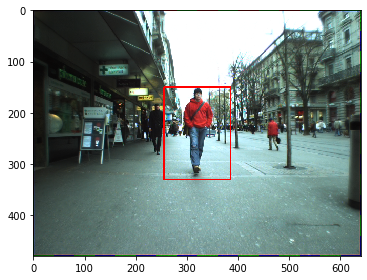

In [ ]:
x,y,w,h=init_box
vis_image=cv2.rectangle(frames[0],(x,y),(x+w,y+h),(255,0,0),2)
skimage.io.imshow(vis_image)

In [ ]:
Video_output_file='/content/drive/MyDrive/Colab Notebooks/tracking.avi'
cc=cv2.VideoWriter_fourcc(*'XVID')
writer=cv2.VideoWriter(Video_output_file,cc,30,(vis_image.shape[1],vis_image.shape[0]),True)


writer.write(vis_image[:,:,::-1])
for i,(x,y,w,h) in enumerate(boxes):
 if x!=0:
   vis_image=cv2.rectangle(frames[i],(x,y),(x+w,y+h),(255,0,0,2))
   writer.write(vis_image[:,:,::-1])
writer.release()

HOG from scratch


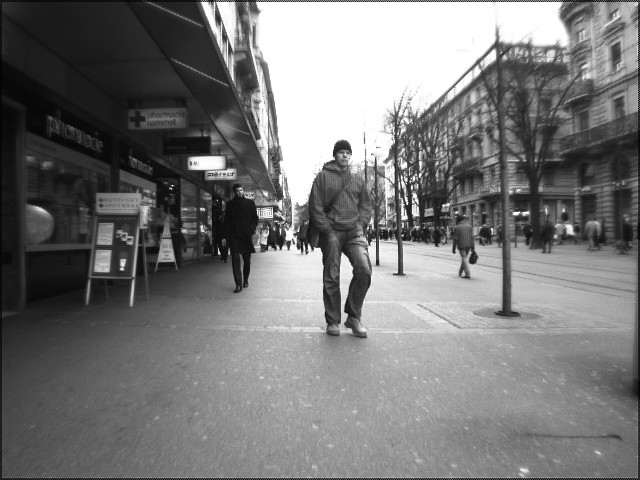

In [ ]:
from google.colab.patches import cv2_imshow
image = cv2.imread('/content/drive/MyDrive/Colab Notebooks/image_00000006_0.png')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cv2_imshow( gray)

In [ ]:
ksize = -1
horizontal_gradient = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
vertical_gradient = cv2.Sobel(gray, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)

In [ ]:

def get_magnitude(horizontal_gradient, vertical_gradient):
    horizontal_gradient_square = np.power(horizontal_gradient, 2)
    vertical_gradient_square = np.power(vertical_gradient, 2)
    sum_squares = horizontal_gradient_square + vertical_gradient_square
    grad_magnitude = np.sqrt(sum_squares)
    return grad_magnitude

def get_direction(horizontal_gradient, vertical_gradient):
    grad_direction = np.arctan(vertical_gradient/(horizontal_gradient))
    grad_direction = np.rad2deg(grad_direction)
    grad_direction = grad_direction%180
    return grad_direction

In [ ]:

direction=get_direction(horizontal_gradient,vertical_gradient)
magnitude=get_magnitude(horizontal_gradient,vertical_gradient)

<ipython-input-26-c1a1bfab13e0>:9: RuntimeWarning: divide by zero encountered in true_divide
  grad_direction = np.arctan(vertical_gradient/(horizontal_gradient))
<ipython-input-26-c1a1bfab13e0>:9: RuntimeWarning: invalid value encountered in true_divide
  grad_direction = np.arctan(vertical_gradient/(horizontal_gradient))
<ipython-input-26-c1a1bfab13e0>:11: RuntimeWarning: invalid value encountered in remainder
  grad_direction = grad_direction%180


In [ ]:
def get_histbincalc(hist_bins, cell_magnitude, cell_direction):
    for i in range(cell_direction.shape[0]):
        for j in range(cell_direction.shape[1]):
            orientation = cell_direction[i, j]
            lower_bin_idx = np.float32(orientation /9)
            lower_bin_idx += cell_magnitude[i, j]

    return np.zeros(hist_bins)/ (cell_magnitude.shape[0] * cell_magnitude.shape[1])

In [ ]:
hist_bins = np.array([10,30,50,70,90,110,130,150,170])
cell_direction = direction[:8, :8]
cell_magnitude = magnitude[:8, :8]
HOG_cell_hist =  get_histbincalc(hist_bins, cell_magnitude, cell_direction)